######  참조 https://www.kaggle.com/dkjung/covid-19-eda-s-korea-forecasting-global?select=time_series_covid_19_recovered.csv

In [2]:
import pip
pip.main(['install', 'pandas_datareader'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [ ]:
## [Environment setting]
from __future__ import print_function

## 0. Basics
import re
import math
import copy
import random
import datetime, time
from operator import add
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from IPython.display import YouTubeVideo
# skipping cells with a long runtime, if True
fast = False
# runtime checker
start_log = datetime.now()

## 1. Data Science
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *
from glob import glob
import missingno as msno
import folium
# import plotly.offline as offline
# import plotly.graph_objs as go

## 2. Statistics
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

## 3. Forecasting
from pandas.plotting import autocorrelation_plot as acplot
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

## 4. Machine Learning
import sklearn
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, r2_score

## 5. Plots & Fonts
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (13, 7)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
color_list = ['#8DD3C7', '#FEFFB3', '#BFBBD9'
              , '#FA8174', '#81B1D2', '#FDB462'
              , '#B3DE69', '#BC82BD', '#CCEBC4']

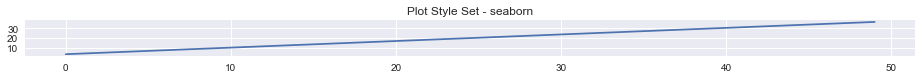

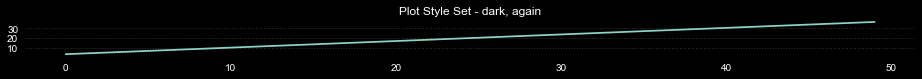

In [21]:

def get_data(path, transpose=False):
    """
    FUNCTION
        to get and check data from a file path
    @ PARAMS
        path(string) = file path for data
        transpose(bool) = transpose a wide data to show vertically / default=False
    > RETURN
        df_raw = dataframe
    """
    df_raw = pd.read_csv(path)
    print('[Sample data]')
    if transpose:
        display(df_raw.head(3).append(df_raw.tail(3)).T)
    else:
        display(df_raw.head(3).append(df_raw.tail(3)))
    return df_raw

def data_range(data, column, describe=None):
    """
    FUNCTION
        to check date range of time series or scarce chronological data
    @ PARAMS
        data(dataframe) = data to check
        column(string) = column name for date
        describe(string) = additional description on date column
                           e.g. starting_date
    > RETURN
        None
    """
    data_col = pd.to_datetime(data[column]).dt.date
    date_range = (max(data_col) - min(data_col)).days + 1
    if describe==None:
        print(f'Date range: {date_range} days')
    else:
        print(f'Date range ({describe}): {date_range} days')
    print(f'# {min(data_col)} to {max(data_col)}')
    return None

## [Refactor point] handle multiple subplots in 1 figure
def plot_groupby(data, groupby, column, title, ylabel=None, axis=None, tick_num=11):
    """
    FUCNTION
        to plot data after grouping by a column
    @ PARAMS
        data = dataframe to plot
        groupby(string) = column name for grouping
        column(string) = column name for y axis
        title(string) = plot title
        axis = specific axis to plot on
    > RETURN
        None
    """
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title(f'{title}', fontsize=17)
    ax.set_xlabel('Date', size=13)
    if ylabel == None:
        ax.set_ylabel('Number of cases', size=13)
    else:
        ax.set_ylabel(ylabel, size=13)
    group_list = data.groupby(groupby)
    for group in group_list:
        if axis == None:
            plt.plot(group[1].date.values
                     , group[1][column].values
                     , label=group[0])
        else:
            axis.plot(group[1].date.values
                     , group[1][column].values
                     , label=group[0])
        """ 
               FUCNTION
               Code Performance
        0. Without .values
            - 558 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 537 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 587 ms ± 34.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        1. With .values 
            - 508 ms ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 515 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 540 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        """
    tick_num = tick_num
    ax.set_xticks(ax.get_xticks()[::int(len(age_raw.date.unique())/tick_num)+1])
    ax.legend()
    plt.show()
    
def plot_lines(data, column_list, column_max, title):
    """
    FUCNTION
        to show many plots with combinations of lines with consistent colors and legend
        useful for plotting lines with different scales at once and then separately
    @ PARAMS
        data = dataframe to plot
        column_list = columns to have numeric values, each can be the initial column to plot up to column_max
        column_max = the last column to plot from the initial column in column_list for len(column_list)
        title(string) = plot title
    > RETURN
        None
    """
    for i in column_list:
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title(f'{title}', fontsize=17)
        color_group = color_list[:-4][-(column_max-i):]
        for test_each, color_each in zip(data.columns[i:column_max], color_group):
            plt.plot(data.date, data[test_each]
                     , label=test_each, color=color_each
                    )
            label=data[test_each]
        ax.set_xticks(ax.get_xticks()[::int(len(data.date)/8)])
        plt.xlabel('Date', size=13)
        plt.ylabel('Number of cases', size=13)
        ax.legend(loc='upper left')
        plt.show()    
    
def split_fit_pred(X, y, model, test_size=0.3, random_state=13, classification=False):
    """
    Function
        to split data into training/test sets, fit a model, and predict with them in one-shot manner
    @params 
        X = independent variables
        y = dependent variable
        model = model to train
        test_size = size of test set / 0<s<1 / default=0.3
        random_state = random seed for stable testing results / default=13
        classification = if classification, split X with stratifying y labels / default=False(linear)
    >return
        model = a fitted model
        prediction = predictions by the model
        train_score = a score by the predictions in training
        test_score = a score by the predictions in test
    """
    # Split
    if classification == True:
        X_train, X_test, y_train, y_test = train_test_split(X, y
                                                            , stratify = y
                                                            , test_size = test_size
                                                            , random_state = random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y
                                                            , test_size = test_size
                                                            , random_state = random_state)
    # Fit & validate
    model.fit(X_train, y_train)
    prediction = model.predict(X_test);
    train_score, test_score = model.score(X_train, y_train), model.score(X_test, y_test)
    return model, prediction, train_score, test_score

def test_with_range(X, y, model, size_range, random_state=13):
    """
    Function
        to test a model with various test set sizes
    @params
        X = independent variables
        y = dependent variable
        model = model to train
        size_range = the range of test sets size to experiment with / 0<s<1
        random_state = random seed for stable testing results / default=13
    @return
        train_list = list of training scores by speicifc value in the given range
        test_list = list of test scores by speicifc value in the given range
        best_test_size = the best size with the best score in test_list
    """
    plt.title(f'Score by Test Set Size (random seed={random_state})', size=17)
    train_list, test_list = list(), list()
    for s in size_range:
        model, prediction, train_score, test_score = split_fit_pred(X, y, model, random_state=random_state, test_size=s)
        train_list.append(train_score); test_list.append(test_score)
    # train_list, test_list
    plt.plot(size_range, train_list)
    plt.plot(size_range, test_list)
    plt.legend(['train_score', 'test_score'])
    plt.xlabel('Test set size')
    plt.ylabel('Score')
    plt.show()
    best_test_size = size_range[np.nanargmax(test_list)]
    print('Best train score: {} (test set size: {})'
          .format(round(np.nanmax(train_list), 2), round(size_range[np.nanargmax(train_list)], 2)))
    print('Best test score: {} (test set size: {})'
          .format(round(np.nanmax(test_list), 2), round(best_test_size, 2)))
    return train_list, test_list, best_test_size
 
## [Refactor point] need to be merged into test_with_range() as both share a lot except for data type
def test_with_range_ts(X, y, model, size_range, variable):
    """
    Function
        to test a model with various sizes on time series data
    @params 
        X = independent variables
        y = dependent variable
        model = model to train
        size_range = the range of test sets size to experiment with / 0<s<1
        random_state = random seed for stable testing results / default=13
    >return
        train_list = list of training scores by speicifc value in the given range
        test_list = list of test scores by speicifc value in the given range
        best_test_size = the best size with the best score in test_list
    """
    X = np.array(X).reshape(-1, 1)
    train_list, test_list, pred_list = list(), list(), list()
    for i in size_range:
        X_train, X_test, y_train, y_test = X[:-i, :], X[-i:, :], y[:-i], y[-i:]
        model.fit(X_train, y_train)
        train_pred = list(model.predict(X_train))
        test_pred = list(model.predict(X_test))
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        train_list.append(train_score)
        test_list.append(test_score)
        pred_list.append(train_pred + test_pred)
    plt.figure(figsize=(13, 7))
    plt.title(f'Score by Test Set Size (%s)'%variable, size=17)
    plt.plot(size_range/len(X), train_list)
    plt.plot(size_range/len(X), test_list)
    plt.legend(['Training score', 'Test score'])
    plt.xlabel('Test set size')
    plt.ylabel('Score')
    plt.show()
    best_score = np.nanmax(test_list)
    best_size = size_range[np.nanargmax(test_list)]
    best_pred = pred_list[np.nanargmax(test_list)]
    print(f'Best training score: %.4f (test set size=%.2f)'%(np.nanmax(train_list)
                                                 , size_range[np.nanargmax(train_list)]/len(X)))
    print(f'Best test score: %.4f (test set size=%.2f)'%(np.nanmax(test_list)
                                                       , best_size/len(X)))
    return train_list, test_list, best_pred, best_score, best_size


def get_recent_to_max(data, group='Country_Region', min_cases=1, recent_window=3, max_num=1):
    """
    FUNCTION 
        to convert raw data with cases by subregion into with that by country
        to add a column measuring which phase of spreading a country is in
            recent_to_max = n latest observation (3 latest, in case the last is 0) 
                            divided by
                            max daily case of a country
    @ PARAMS 
        data = data to convert
        group = criterion for grouping target values
        min_caes = minimum number of cases in a country to be listed /default=1
        recent_window = how many observations to apply in recent_to_max calculation / default=3
        max_num = number of max values to be averaged (1st max, 2nd max, ..., Nth max) / default=1
    > RETURN 
        rtm_df = DataFrame with columns of total_cases and recent_to_max (indexed by country)
        data_group = DataFrame grouped by group column
    """
    ## 1. Get source data by country / set dictionary to save total cases and recent_to_max
    data_group = data.groupby(group)
    total_dict, rtm_dict = dict(), dict()
    for i in data_group:
        if i[1].TargetValue.sum() > min_cases:
            total_dict[i[0]] = i[1].TargetValue.sum()
    ## 2-1. Handle 0 latest cases (for being robust to the exceptional 0 day)
            if i[1].TargetValue.max() in i[1].TargetValue[-recent_window:].values:
                rtm_dict[i[0]] = 1
            else:
    ## 2-2. Average N max values (for being robust to the errorneous max value)
                if max_num > 1:
                    temp = copy.deepcopy(i[1].TargetValue)
                    max_list = list()
                    for j in range(max_num):
                        max_list.append(max(temp))
                        temp.pop(np.argmax(temp))
                    max_val = np.mean(max_list)
                else:
                    max_val = i[1].TargetValue.max()
                rtm_dict[i[0]] = i[1].TargetValue[-recent_window:].mean() / max_val
    ## 3. Get the result dataframe
    rtm_df = pd.DataFrame(np.array([list(total_dict.values()), list(rtm_dict.values())]).T
                          , index = total_dict.keys()
                          , columns = ['total_cases', 'recent_to_max'])
    rtm_df = rtm_df.sort_values('total_cases', ascending=False)
    return rtm_df, data_group


def plot_phase(data_grouped, rtm_df, no_of_country=3, trim=False, scale=False, reverse=False):
    """
    FUNCTION 
        to plot the daily confirmed cases for each country
        to check in which phase (early, middle, late) of spreading it is
    @ PARAMS 
        group = list of time series data grouped by a column
        rtm_df = dataframe with total_cases and recent_to_max columns per country
        no_of_country = number of countries to plot
        trim = starts from the day with 1st case (than the given first)
        scale = scale target values to the max in a given period
        reverse = reverse the given order of index
    > RETURN 
        None
    """
    ## 1. Set list of countries to plot
    if reverse:
        country_list = rtm_df.index[-no_of_country:][::-1]
    else:
        country_list = rtm_df.index[0:no_of_country]
    ## 2. Plot daily cases for each country
    for i, j in zip(country_list, np.arange(1, len(country_list)+1)):
        group = data_grouped.get_group(i)
        if trim:
            # starts from the day with 1st case
            first_case_idx = int(group[group.TargetValue > 0].head(1).index.values)
        else:
            first_case_idx = 0
        group = group.loc[first_case_idx:, :] # loc than iloc
        group = group.groupby('Date').sum()
        group = group.loc[ :, ['TargetValue'] ]
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title('Daily Confirmed Cases - {0}. {1} (total cases={2}, recent to max={3})'.format(j, i
                          , int(rtm_df.loc[i, "total_cases"])
                          , round(rtm_df.loc[i, "recent_to_max"], 4))
                  , size=17)
        if scale:
            group.TargetValue = group.TargetValue / max(group.TargetValue) * 100
        ax.plot(group.index
                , group.TargetValue)
        ax.set_xticks(ax.get_xticks()[::int(len(group.index)/8)])
        ax.set_xlabel('Confirmed date')
        ax.set_ylabel('Number of cases', size=13)
    return None
    
def arima_grid(truth, p_anchor, d_anchor, q_anchor, window):
    """
    FUNCTION
        to grid search for ARIMA model parameters (p, d, q)
    @ PARAMS
        truth = dataframe saving Date and TargetValue columns
        p_anchor, d_anchor, q_anchor = mid point for list of possible parameters
        window = range of extending anchor values (-/+ window applied to each anchor)
    > RETURN
        param_list = list of parameter sets
        mape_list = list of MAPE per each parameter sets
    """
    p_range = np.arange(max(0, p_anchor-window), p_anchor+window+1)
    d_range = np.arange(max(0, d_anchor-window), d_anchor+window+1)
    q_range = np.arange(max(0, q_anchor-window), q_anchor+window+1)
    param_list, mape_list = list(), list()
    for p in p_range:
        for d in d_range:
            for q in q_range:
                arima = ARIMA(truth.TargetValue
                              , dates=truth.Date
                              , order=(p, d, q)
                              , freq="D").fit()
                arima_pred = arima.predict()
                _, _, _, mape = diff_metrics(truth.TargetValue[:-1], arima_pred[1:])
                param_list.append(f'{p}, {d}, {q}')
                mape_list.append(mape)
    plt.plot(param_list, mape_list)
    plt.title('MAPE by parameter set (p, d, q)', size=17)
    plt.xlabel('Parameter set', size=13)
    plt.ylabel('MAPE (Mean Absolute Percentage Error)', size=13)
    plt.xticks(rotation=31)
    plt.show()
    return param_list, mape_list

def do_prophet(data, date_column, y_column
               , benchmark=None, test_size=1
               , is_bench=False, bm_name='best model at present'
               , season_mode='additive', custom_period=False, period=None, num_curve=5
               , simple=True
               ):
    """
    Function 
        to apply Prophet with default parameters
    @Params 
        data = data before being formatted in Prophet manner
        date_column = column name for time steps
        y_column = column name for independent variable
        benchmark = benchmark prediction to plot
        test_size = size for forecasting / 1<s<len(data) / default=1
        is_bench = if is_bench, plot benchmark prediction too / default=True
        bm_name = name (or description) for benchmark method
        sesson_mode = the mode for calculating seasonality / default='additive', optional='multiplicative'
        custom_period = set and use custom period
        period = custom period / format='n days(or other time unit)'
        num_curve = how many curves are allowed / default=5 / the more, the more flexible, prone to overfitting, and time need to fit
        simple = if simple, don't print out intermediate details (only plot the last prediction plot) / default=True
    >return 
        pp = the fitted Prophet model (useful for cross validation)
        predict = the predictions by the model (useful for visualization)
    """
     ## 1. Prepare a dataframe
    forecast_df = data[ [date_column, y_column] ]
    if not simple:
        print('[Raw Data - sample]')
        display(forecast_df.head(3).append(forecast_df.tail(3)))
    forecast_df = data.rename(columns = {date_column: 'ds' # ds: Date Stamp
                                         , y_column: 'y'}) # y: values to forecast
    # forecast_df.ds = pd.to_datetime(forecast_df.ds) # string to datetime
    ## 2. Split
    forecast_train, forecast_test = forecast_df.iloc[:-test_size, :], forecast_df.iloc[-test_size:, :]
    if not simple:
        print(f'Training-set size: %d\nTest-set size: %d\n'%(forecast_train.shape[0], forecast_test.shape[0]))
    ## 3. Fit
    if custom_period:
        pp = Prophet(\
                     seasonality_mode=season_mode
                     , yearly_seasonality=False
                     , weekly_seasonality=False
                     , daily_seasonality=False
                    ).add_seasonality(name='custom'
                                      , period=period
                                      , fourier_order=num_curve)
    else:
        pp = Prophet()
    pp.fit(forecast_train)
    if not simple:
        print('# Prophet model trained\n')
    ## 4. Predict
    frame = pp.make_future_dataframe(periods=test_size)
    predict = pp.predict(frame)
    if not simple:
        print('[Forecasting result - sample]')
        display(predict.tail(3).T)
        print('# yhat = predicted point value')
    ## 5. Plot predictions
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title('Confirmed Cases Prediction (Prophet)', size=17)
    plt.plot(forecast_df.ds, forecast_df.y
             , color='#33322B', ls=':', lw=3)
    plt.plot(forecast_df.ds, predict.yhat)
    if is_bench:
        plt.plot(forecast_df.ds, benchmark)
    ax.axvline(forecast_df.ds.values[len(forecast_df)-test_size], ls=':', color='crimson')
    ax.set_xticks(ax.get_xticks()[::int(len(forecast_df.ds)/8)])
    if is_bench:
        ax.legend(['Truth'
                   , 'Prediction (Prophet)'
                   , f'Benchmark (%s)'%bm_name
                   , 'Test starts']
                  , fontsize=11
                  , loc='upper left'
                 )
    else:
        ax.legend(['Truth'
                   , 'Prediction (Prophet)'
                   , 'Test starts']
                  , fontsize=11
                  , loc='upper left'
                 )
    plt.xlabel('Confirmed date', size=13)
    plt.ylabel('Number of cases', size=13)
    plt.show()
    return pp, predict

## [Refactor point] need to embrace multi-steps forecasting
def result_df(date, truth, pred):
    """
    FUNCTION 
        to make a dataframe for test results for one-step forecasting
    @ PARAMS 
        date(string) = column name for date
        truth(numeric) = truth value
        pred(numeric) = predicted value
    > RETURN 
        result = result dataframe with 'truth, prediction, difference(truth-prediction)' as columns
    """
    col = ['truth', 'prediction', 'difference']
    result = pd.DataFrame(columns=[col], index=[date])
    result.loc[date, 'truth'] = truth
    result.loc[date, 'prediction'] = pred
    result.loc[date, 'difference'] = abs(truth-pred)
    return result

def diff_metrics(truth, pred):
    """
    FUNCTION
        to calculate difference (predictions-truth) and the performance metrics
    @ PARAMS
        truth(sequences of numeric values) = truth values
        pred(sequences of numeric values) = predicted values
    > RETURN
        diff = pred - truth
        rmse = Root Mean Sqaure Error
        mae = Mean Absolute Error
        mape = Mean Absolute Percentage Error
    """
    diff = np.array(pred) - np.array(truth)
    rmse = np.sqrt(np.mean(diff**2))
    mae = np.mean(np.abs(diff))
    mape = np.mean(np.abs(diff) / (np.array(truth) + 1))
    return diff, rmse, mae, mape

def perform_report(truth, pred):
    """
    FUNCTION
        to get performance report as dataframes (dependent on diff_metrics())
    @ PARAMS
        truth(sequences of numeric values) = truth values
        pred(sequences of numeric values) = predicted values
    > RETURN
        result = dataframe with columns of 'truth, prediction, difference'
        metrics = dataframe with columns of 'rmse, mae, mape'
    """
    diff, rmse, mae, mape = diff_metrics(truth, pred)
    result = pd.DataFrame(
        {'truth': truth
         , 'prediction': pred
         , 'difference': diff}
    )
    metrics = pd.DataFrame(
        {'rmse': rmse
         , 'mae': mae
         , 'mape': mape}
        , index=['score']
    )
    display(result)
    display(metrics)
    return result, metrics

def set_style():
    """
    FUNCTION
        to set color theme with a custom dark, plus additional style settings like figsize
    @ PARAMS
        None
    > RETURN
        None
    """
    plt.style.use('seaborn')
    plt.figure(figsize=(13, 1.3))
    plt.title('Plot Style Set - seaborn')
    plt.plot(np.linspace(np.pi, np.pi**np.pi))
    plt.show()
    plt.style.use('dark_background')
    plt.rcParams['axes.grid.axis'] = 'y'
    plt.rcParams['grid.linestyle'] = ':'
    plt.rcParams['grid.color'] = '#33322B'
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.figsize'] = (13, 7)
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(13, 1.3))
    plt.title('Plot Style Set - dark, again')
    plt.plot(np.linspace(np.pi, np.pi**np.pi))
    plt.show()
    
set_style()


In [29]:
import os
last_update = '2020-06-30'
print(f'[Dataset list]\n# updated on %s'%last_update)
file_paths_raw = []
for dirname, _, filenames in os.walk('C:/Users/junho/nanodegree-python/data/covid-19'):
    for filename in filenames:
        file_paths_raw.append(os.path.join(dirname, filename))
file_names = ['TimeAge.csv', 'TimeProvince.csv', 'Region.csv', 'TimeGender.csv'
              , 'Time.csv', 'Case.csv', 'Weather.csv', 'PatientInfo.csv'
              , 'SeoulFloating.csv', 'SearchTrend.csv', 'Policy.csv']
file_paths = [ j for i in file_names for j in file_paths_raw if i in j ]
file_paths

[Dataset list]
# updated on 2020-06-30


['C:/Users/junho/nanodegree-python/data/covid-19\\TimeAge.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\TimeProvince.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\Region.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\TimeGender.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\Time.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\Case.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\Weather.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\Weather.csv.zip',
 'C:/Users/junho/nanodegree-python/data/covid-19\\PatientInfo.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\SeoulFloating.csv.zip',
 'C:/Users/junho/nanodegree-python/data/covid-19\\SearchTrend.csv',
 'C:/Users/junho/nanodegree-python/data/covid-19\\Policy.csv']

## Age

[Sample data]


,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
1086,2020-06-30,0,60s,1668,41
1087,2020-06-30,0,70s,850,82
1088,2020-06-30,0,80s,556,139


Date range: 121 days
# 2020-03-02 to 2020-06-30
Age groups: ['0s' '10s' '20s' '30s' '40s' '50s' '60s' '70s' '80s']
# 80s == 80s and older


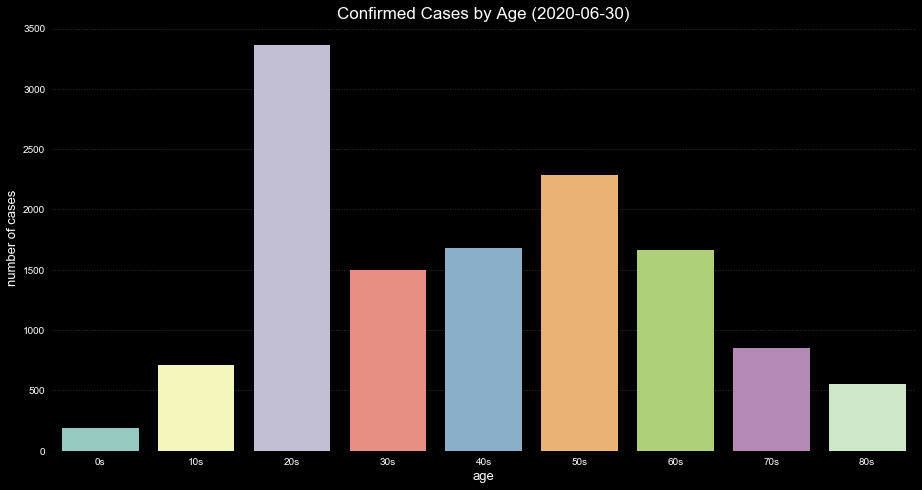

In [30]:
## 1. Get / Check data
age_raw = get_data(file_paths[0])
data_range(age_raw, 'date')
age_list = age_raw.age.unique()
print('Age groups:', age_list)
print('# 80s == 80s and older')

## 2. Plot cases by age
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Confirmed Cases by Age ({last_update})', fontsize=17)
sns.barplot(age_list, age_raw.confirmed[-9:])
ax.set_xlabel('age', size=13)
ax.set_ylabel('number of cases', size=13)
plt.show()

,age,population,proportion
1,50s,8587047,16.58
2,40s,8291728,16.01
3,30s,7203550,13.91
4,20s,6971785,13.46
5,60s,6472987,12.50
6,10s,4732100,9.14
7,0s,4055740,7.83
8,70s,3591533,6.94
9,80s,1874109,3.62


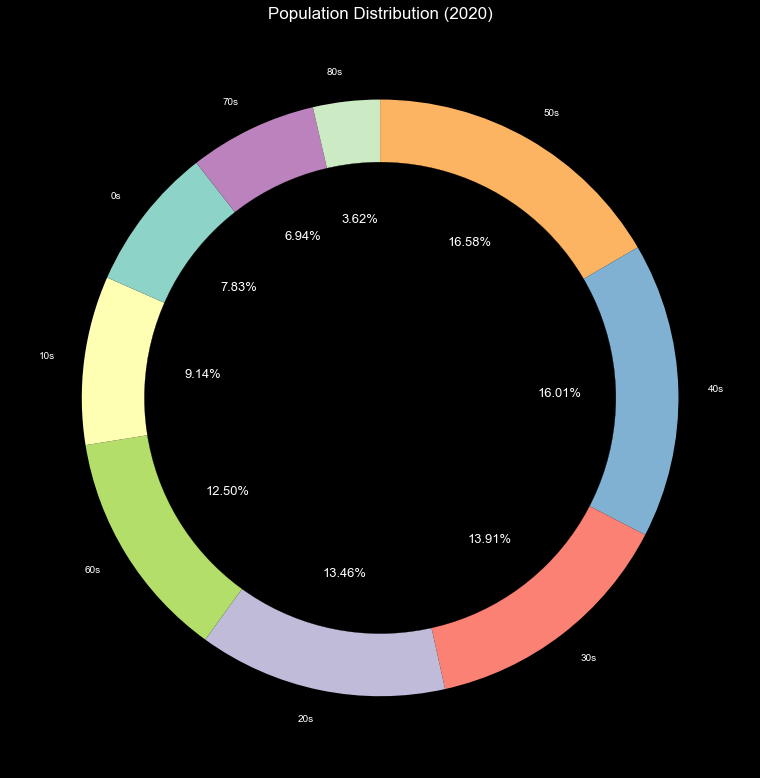

In [31]:
## 1. Get population distribution table
pop_order = pd.DataFrame()
pop_order['age'] = age_list
pop_order['population'] = (4055740, 4732100, 6971785, 7203550, 8291728, 8587047, 6472987, 3591533, 1874109)
pop_order['proportion'] = round(pop_order['population']/sum(pop_order['population']) * 100, 2)
pop_order = pop_order.sort_values('population', ascending=False)
pop_order.set_index(np.arange(1, 10), inplace=True)
display(pop_order)

## 2. Plot population distribution
    # code source for donut chart: https://python-graph-gallery.com/162-change-background-of-donut-plot/
color_pie = [color_list[5], color_list[4], color_list[3]
             , color_list[2], color_list[6], color_list[1]
             , color_list[0], color_list[7], color_list[8]]
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Population Distribution (2020)', fontsize=17)
pop_circle = plt.Circle((0,0), 0.79, color='black')
plt.pie(pop_order.proportion
        , labels = pop_order.age
        , autopct = '%.2f%%'
        , colors = color_pie
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

,age,population,proportion,confirmed,confirmed_rate
7,0s,4055740,7.83,193,0.004759
6,10s,4732100,9.14,708,0.014962
4,20s,6971785,13.46,3362,0.048223
3,30s,7203550,13.91,1496,0.020768
2,40s,8291728,16.01,1681,0.020273
1,50s,8587047,16.58,2286,0.026621
5,60s,6472987,12.50,1668,0.025769
8,70s,3591533,6.94,850,0.023667
9,80s,1874109,3.62,556,0.029667


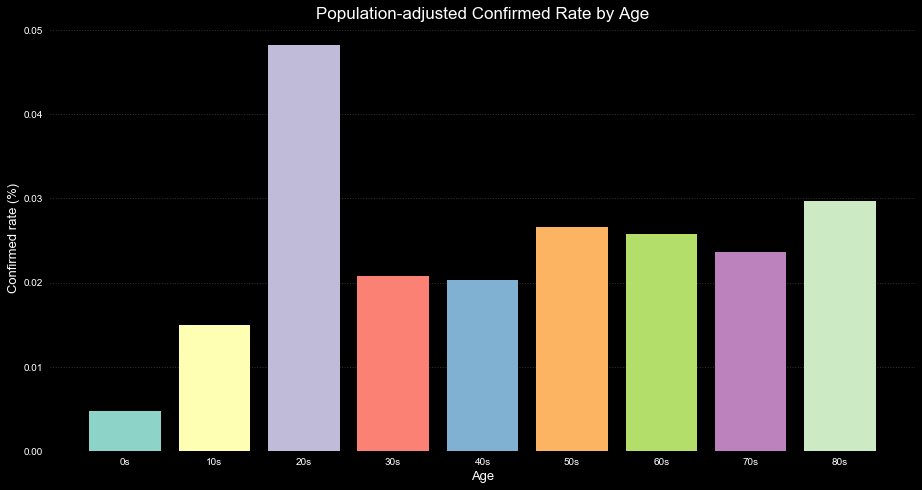

In [33]:
# 1.연령별 인구 / 비율을 가진 새로운 테이블 얻기
confirmed_by_population = pop_order.sort_values('age')
confirmed_by_population['confirmed'] = list(age_raw[-9:].confirmed)

# 2. 인구에 대한 확인된 비율 얻기
confirmed_by_population['confirmed_rate'] = confirmed_by_population['confirmed']/confirmed_by_population['population']*100;
display(confirmed_by_population)
# 3. 연령별 비율 그래프
fig, ax = plt.subplots(figsize = (13,7))
plt.title('Population-adjusted Confirmed Rate by Age', fontsize=17)
ax.bar(age_list, confirmed_by_population.confirmed_rate[-9:], color=color_list)
ax.set_xlabel('Age', size=13)
ax.set_ylabel('Confirmed rate (%)', size=13)
plt.show()

######  처음 그래프랑 두개 합치기

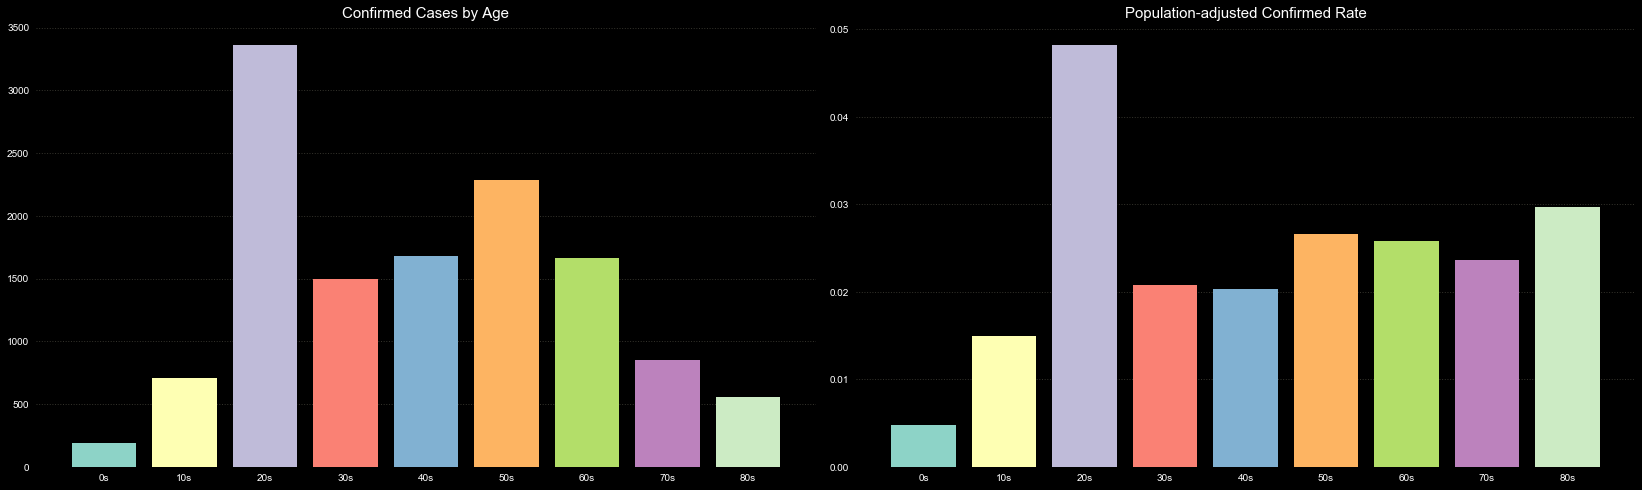

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 7))

## 1. Absolute numbers
axes[0].set_title('Confirmed Cases by Age', fontsize=15)
axes[0].bar(age_list, confirmed_by_population.confirmed, color=color_list)

## 2. Confirmed rate
axes[1].set_title('Population-adjusted Confirmed Rate', fontsize=15)
axes[1].bar(age_list, confirmed_by_population.confirmed_rate, color=color_list)

plt.show()

###### 1. 나이가 들수록 일반적으로 감염되기가 쉽다 
###### 2. 20대가 가장 많이 감염된 그룹이다

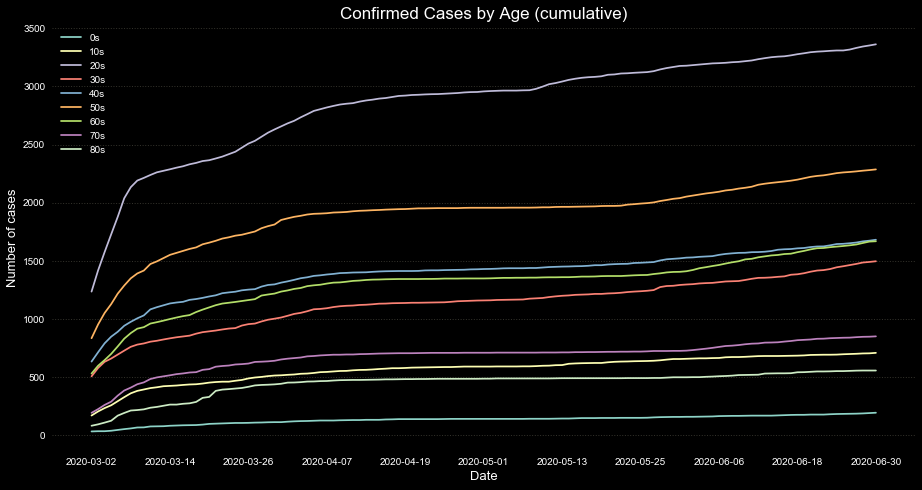

In [42]:
# 시간별로 
plot_groupby(age_raw, 'age', 'confirmed', 'Confirmed Cases by Age (cumulative)')

######  20대와 다른 나이대 사이의 격차는 2020.03.08까지 넓게 유지됬다
###### 그 후 모든 연령대에서 기울기가 완만해졌다
###### 20대가 다른연령보다 3.23~5.7일까지 많이 증가했다

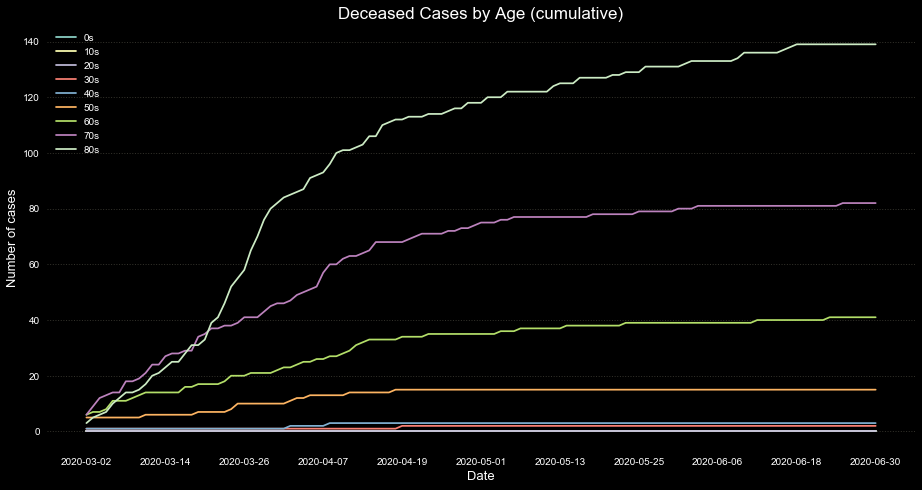

[Latest deceased cases]


,0,1,2,3,4,5,6,7,8
age,0s,10s,20s,30s,40s,50s,60s,70s,80s
deceased,0,0,0,2,3,15,41,82,139


In [43]:
# 사망한사례 그래프
plot_groupby(age_raw, 'age', 'deceased', 'Deceased Cases by Age (cumulative)')

# 절대수 확인
age_deceased = age_raw.tail(9)[['age', 'deceased']]
age_deceased.set_index(np.arange(0, len(age_raw.age.unique())), inplace=True)
print('[Latest deceased cases]')
display(age_deceased.T)

###### 70대와 80대가 제일 위에 있다
###### 20대의 경우 감염자수는 약 3500명인데 사망자는 0이다

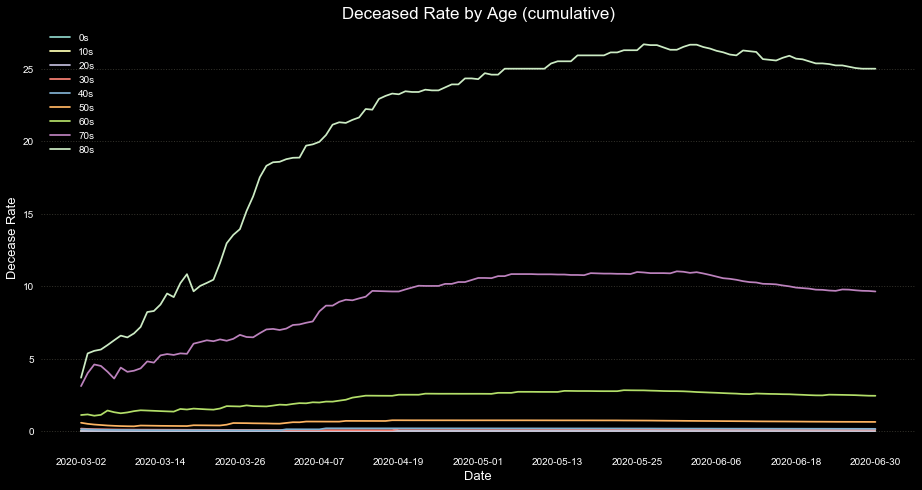

In [45]:
# 사망률 컬럼 추가
age_raw['deceased_rate'] = age_raw.deceased/age_raw.confirmed *100.0

# 시간별 사망률 그래프
plot_groupby(age_raw, 'age', 'deceased_rate', 'Deceased Rate by Age (cumulative)', 'Decease Rate')

###### 80대는 70대보다 2배넘은 사망률을 나타낸다
###### 5월 말부터 조금씩 감소한다
###### 다른 나이대는 안정적이다?

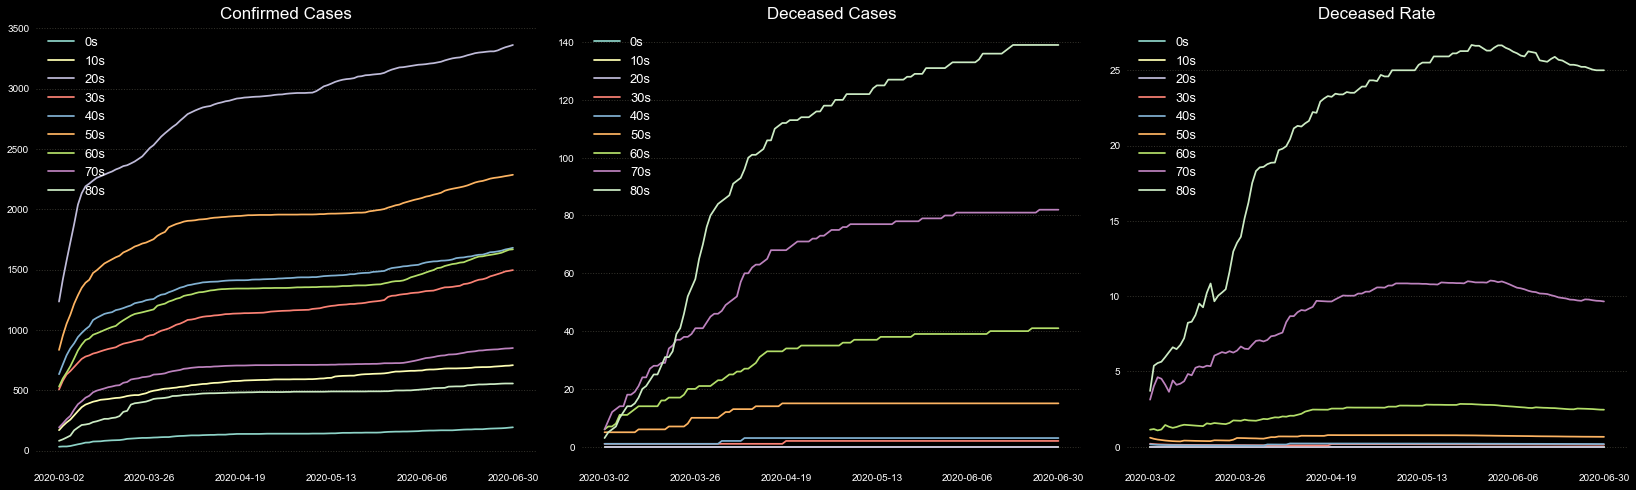

In [48]:
# 3개의 그래프 나타내기
if not fast:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23,7))
    sub_list = [age_raw.confirmed, age_raw.deceased, age_raw.deceased_rate]
    title_list = ['Confirmed Cases', 'Deceased Cases', 'Deceased Rate']
    for sub, i, title in zip(sub_list, range(len(sub_list)), title_list):
        confirmed_set = sub.groupby(age_raw.age)
        for confirmed_each, age_each in zip(confirmed_set, age_list):
            axes[i].plot(age_raw.date.unique(), confirmed_each[1], label=age_each)
            axes[i].set_title(title, size=17)
        axes[i].set_xticks(axes[i].get_xticks()[::int(len(age_raw.date.unique())/5)])
        axes[i].legend(fontsize=13)